#### Reminder. ECDF

In [1]:
import numpy as np
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n + 1) / n

    return x, y

## 1. Formulating and simulating a hypothesis
When we studied linear regression, we assumed a linear model for how the data are generated and then estimated the parameters that are defined by that model. 

#### 2008 US swing state election results
But, how to we assess how reasonable it is that our observed data are actually described by the model? This is the realm of hypothesis testing. Let's start by thinking about a simpler scenario. 

Consider the following Ohio and Pennsylvania are similar states. They are neighbors and they both have liberal urban counties and also lots of rural conservative counties

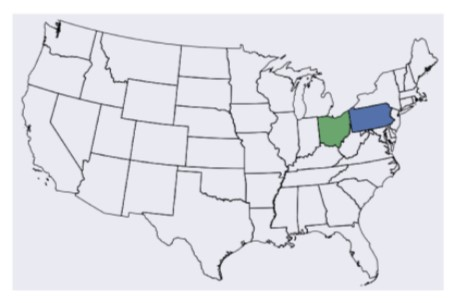

In [2]:
from IPython.display import Image
## Hình minh họa Image(fig1, height, width)

#### Hypothesis testing
We hypothesize that county-level voting in these two states have identical probability distributions. We have voting data to help test if this hypothesis. Stated more concretely, we are going to assess how reasonable the observed data are assuming the hypothesis is true. 

- The hypothesis we are testing is typically called the **null hypothesis**. We might start by just plotting the two ECDFs of the county-level votes. 
- Pennsylvania seems to be slightly more toward Obama in the middle part of the ECDFs, but not much. We can't really draw a conclusion here.

#### Percent vote for Obama
We could just compare some summary statistics. 

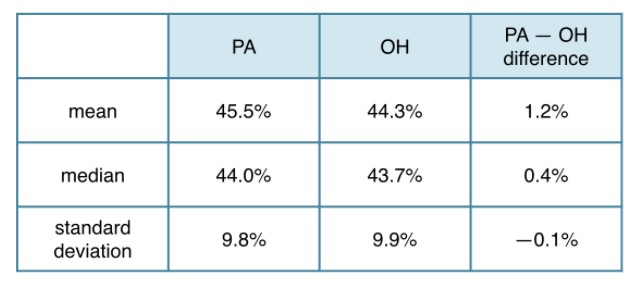

In [3]:
## Hình minh họa Image(fig1, height, width)

Again, this is a tough call. 
- The means and medians of the two states are really close, and the standard deviations are almost identical. 
- So eyeballing the data is not enough.

#### Simulating the hypothesis
To resolve this issue, we can simulate what the data would look like if the county-level voting trends in the two states were identically distributed. 
- We can do this by putting the Democratic share of the vote for all of Pennsylvania's 67 counties and Ohio's 88 counties together.

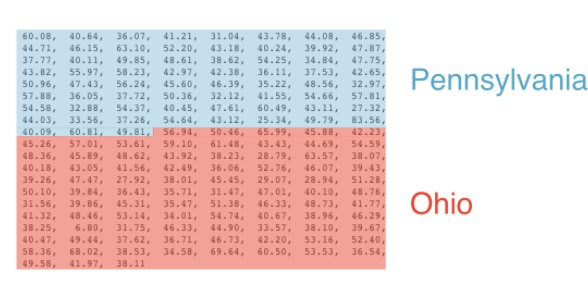

In [4]:
## Hình minh họa Image(fig1, height, width)

We then ignore what state they belong to. 

- Next, we randomly scramble. We then re-label the first 67 to be `"Pennsylvania"` and the remaining ones to be `"Ohio".` 

So, we just redid the election as if there was no difference between Pennsylvania and Ohio.

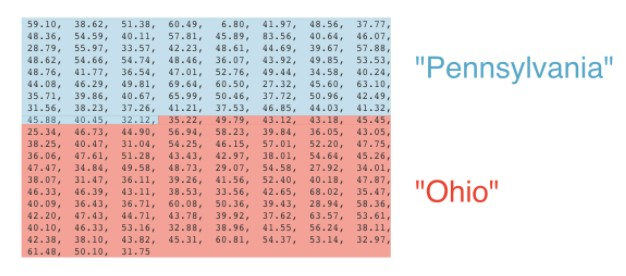

In [5]:
## Hình minh họa Image(fig1, height, width)
Image(r'../input/thinkstatsfigures2/Part2_chap3_fig4.jpg', height = 121, width = 430)

#### Permutation
This technique, of scrambling the order of an array, is called a permutation. It is at the heart of simulating a null hypothesis were we assume two quantities are identically distributed.
#### Generating a permutation sample
Let's look at how we can implement this in Python. 

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

election = pd.read_table(r'../input/think-stats-dataset/2008 election results (swing states).txt', sep = ',')
dem_share_PA = election.dem_share[election['state'] == 'PA'].values
dem_share_OH = election.dem_share[election['state'] == 'OH'].values

- First, we need to make a single array with all of the counties in it. We do this using the `np.concatenate` function. Notice that this function takes a tuple of the arrays you wish to concatenate as an argument. 

In [7]:
dem_share_both = np.concatenate([dem_share_PA, dem_share_OH])

- Next, we use the function np dot random dot permutation to conveniently permute the entries of the array.

In [8]:
dem_share_perm = np.random.permutation(dem_share_both)

- We then assign the first 67 to be labeled Pennsylvania and the last 88 to be labeled Ohio.

In [9]:
perm_sample_PA = dem_share_perm[: len(dem_share_PA)]
perm_sample_OH = dem_share_perm[len(dem_share_PA) :]

These samples are called **permutation samples**.

### 1.2. PRACTICES
#### Exercise 1.2.1. Generating a permutation sample
In the theory, you learned that permutation sampling is a great way to simulate the hypothesis that two variables have identical probability distributions. This is often a hypothesis you want to test, so in this exercise, you will write a function to generate a permutation sample from two data sets.

Remember, a permutation sample of two arrays having respectively `n1` and `n2` entries is constructed by concatenating the arrays together, scrambling the contents of the concatenated array, and then taking the first `n1` entries as the permutation sample of the first array and the last `n2` entries as the permutation sample of the second array.

#### SOLUTION.

In [10]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[: len(data1)]
    perm_sample_2 = permuted_data[len(data1): ]

    return perm_sample_1, perm_sample_2

#### Exercise 1.2.2. Visualizing permutation sampling
To help see how permutation sampling works, in this exercise you will generate permutation samples and look at them graphically.

We will use the Sheffield Weather Station data again, this time considering the monthly rainfall in June (a dry month) and November (a wet month). We expect these might be differently distributed, so we will take permutation samples to see how their ECDFs would look if they were identically distributed.

The data are stored in the Numpy arrays `rain_june` and `rain_november`.
#### SOLUTION

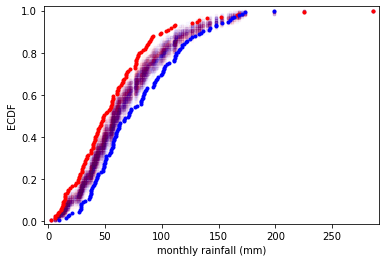

In [12]:
for _ in range(50):
    # Generate permutation samples
    perm_sample_1, perm_sample_2 = permutation_sample(rain_june, rain_november)


    # Compute ECDFs
    x_1, y_1 = ecdf(perm_sample_1)
    x_2, y_2 = ecdf(perm_sample_2)

    # Plot ECDFs of permutation sample
    _ = plt.plot(x_1, y_1, marker='.', linestyle='none',
                 color='red', alpha=0.02)
    _ = plt.plot(x_2, y_2, marker='.', linestyle='none',
                 color='blue', alpha=0.02)

# Create and plot ECDFs from original data
x_1, y_1 = ecdf(rain_june)
x_2, y_2 = ecdf(rain_november)
_ = plt.plot(x_1, y_1, marker='.', linestyle='none', color='red')
_ = plt.plot(x_2, y_2, marker='.', linestyle='none', color='blue')

# Label axes, set margin, and show plot
plt.margins(0.02)
_ = plt.xlabel('monthly rainfall (mm)')
_ = plt.ylabel('ECDF')
plt.show()

## 2. Test statistics and p-values
Now that we know how to simulate the null hypothesis using permutation, we can start to test it.
### 2.1. Theory.
#### Null hypothesis: Are OH and PA different?
We will continue our study of hypothesis testing with the Ohio/Pennsylvania vote data. 
- We are testing the null hypothesis that the county-level voting is identically distributed between the two states. 
- Remember that testing a hypothesis is an assessment of how reasonable the observed data are assuming the hypothesis is true.
- But this is a bit vague. 
- What about the data do we assess and how do we quantify the assessment?
- The answer to these questions hinges on the concept of a test statistic.

#### Test statistic.
A test statistic is a single number that can be computed from observed data and also from data you simulate under the null hypothesis. 

- It serves as a basis of comparison between what the hypothesis predicts and what we actually observed. 
- Importantly, you should choose your test statistic to be something that is pertinent to the question you are trying to answer with your hypothesis test, in this case, are the two states different? 

If they are identical, they should have the same mean vote share for Obama. So the difference in mean vote share should be zero.

We will therefore choose the difference in means as our test statistic.

In [13]:
np.mean(perm_sample_PA) - np.mean(perm_sample_OH)

1.2233024762550881


#### Permutation replicate
From the permutation sample we generated in the last section-theory, the value of the test statistic is `1.22%`. 

The value of a test statistic computed from a permutation sample is called a permutation replicate, in this case, `1.22%`. 

In [14]:
np.mean(dem_share_PA) - np.mean(dem_share_OH)

1.1582360922659447

We already calculated that the difference in mean vote share from the actual election was `1-point-16%`. 

So, for this permutation replicate, we did not quite get as big of a difference in means than what was observed in the original data. Now, we can "redo" the election 10,000 times under the null hypothesis by generating lots and lots of permutation replicates. (You will write for loops to do this in the exercises.)
#### Mean vote difference under null hypothesis
We can plot a histogram of all the permutation replicates. The difference of means from the elections simulated under the null hypothesis lies somewhere between -4 and 4%. 

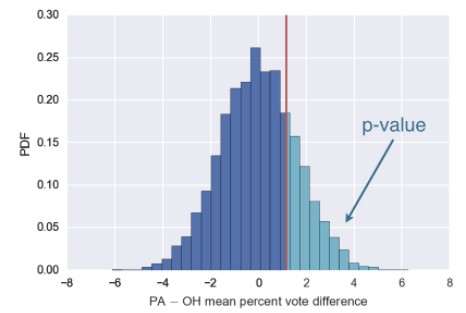

In [15]:
## Hình minh họa Image(fig1, height, width)

The actual mean percent vote difference was `1.16%`, shown by the red line.

If we tally up the area of the histogram that is to the right of the read line, we get that about `23%` of the simulated elections had at least a 1-point-16% difference or greater. This value, `1.23%`, is called the `p-value`.
#### p-value
It is the probability of getting at least a `1.16`% difference in the mean vote share assuming the states have identically distributed voting. 

So is it plausible that we would observe the vote share we got if Pennsylvania and Ohio had identically distributed county-level voting? Sure it is. It happened `23%` of the time under the null hypothesis. 

Now, we have to be careful about the definition of the `p-value`. 

Again, the `p-value` is the probability of obtaining a value of your test statistic that is at least as extreme as what was observed, under the assumption the null hypothesis is true. The `p-value` is exactly that. It is not the probability that the null hypothesis is true.
- Further, the `p-value` is only meaningful if the null hypothesis is clearly stated, along with the test statistic used to evaluate it. 
- When the `p-value` is **small**, it is often said that the data are **statistically significantly different than what we would observe under the null hypothesis**. For this reason, the hypothesis testing we're doing is sometimes called **null hypothesis significance testing**, or NHST. 

#### Null hypothesis significance testing (NHST)
I encourage you not to just label something as statistically significant or not, but rather to consider the value of the p-value, as well as how much different the data are from what you would expect from the null hypothesis.

#### Statistical significance ? practical significance
Remember: **statistical significance** (that is, **low `p-values`**) and practical significance, whether or not the difference of the data from the null hypothesis matters for practical considerations, are two different things.

### 2.2. PRACTICES
#### Exercise 2.2.1. Test statistics
When performing hypothesis tests, your choice of test statistic should be:
#### Answers.
When performing hypothesis tests, your choice of test statistic should be: **pertinent to the question you are seeking to answer in your hypothesis test**. Remember: the most important thing to consider is: What are you asking?

#### Exercise 2.2.2. What is a p-value?
The `p-value` is generally a measure of??
#### Answers.
The `probability` of **observing a test statistic equally or more extreme than** the one you observed, **given that the null hypothesis is true**.

#### Exercise 2.2.3. Generating permutation replicates
As discussed in the video, a permutation replicate is a single value of a statistic computed from a permutation sample. As the draw_bs_reps() function you wrote in chapter 2 is useful for you to generate bootstrap replicates, it is useful to have a similar function, draw_perm_reps(), to generate permutation replicates. You will write this useful function in this exercise.

The function has call signature `draw_perm_reps(data_1, data_2, func, size=1)`. Importantly, `func` must be a function that takes two arrays as arguments. In most circumstances, `func` will be a function you write yourself.
#### SOLUTION.

In [16]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

#### Exercise 2.2.4. Look before you leap: EDA before hypothesis testing
`Kleinteich and Gorb (Sci. Rep., 4, 5225, 2014)` performed an interesting experiment with South American horned frogs. They held a plate connected to a force transducer, along with a bait fly, in front of them. They then measured the impact force and adhesive force of the frog's tongue when it struck the target.

`Frog A` is an adult and `Frog B` is a juvenile. 

The researchers measured the impact force of 20 strikes for each frog. In the next exercise, we will test the hypothesis that the two frogs have the same distribution of impact forces. 

But, remember, it is important to do `EDA` first! Let's make a bee swarm plot for the data. They are stored in a Pandas data frame, `df`, where column `ID` is the identity of the frog and column `impact_force` is the impact force in Newtons `(N)`.
#### SOLUTION.

In [17]:
df = pd.read_table(r'../input/think-stats-dataset/Frog tongue data.txt', 
                   sep = ',', usecols = ['ID', 'impact force (mN)'])

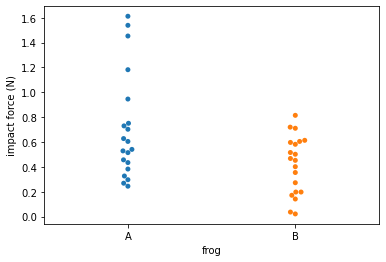

In [18]:
# Make bee swarm plot
_ = sns.swarmplot(x='ID', y='impact_force', data=df)

# Label axes
_ = plt.xlabel('frog')
_ = plt.ylabel('impact force (N)')

# Show the plot
plt.show()

#### Exercise 2.2.5. Permutation test on frog data
The average strike force of Frog A was 0.71 Newtons (N), and that of Frog B was 0.42 N for a difference of 0.29 N. It is possible the frogs strike with the same force and this observed difference was by chance. You will compute the probability of getting at least a 0.29 N difference in mean strike force under the hypothesis that the distributions of strike forces for the two frogs are identical. We use a permutation test with a test statistic of the difference of means to test this hypothesis.

For your convenience, the data has been stored in the arrays `force_a` and `force_b`.
#### SOLUTION.

In [19]:
force_a = df.impact_force[df['ID'] == 'A'].values
force_b = df.impact_force[df['ID'] == 'B'].values

def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(force_a, force_b)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(force_a, force_b,
                                 diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)

p-value = 0.0056


## 4. Bootstrap hypothesis tests
### 4.1. Theory.
#### Pipeline for hypothesis testing
- First, clearly state the null hypothesis. Stating the null hypothesis so that it is crystal clear is essential to be able to simulate it.
- Next, define your test statistic. 
- Then generate many sets of simulated data assuming the null hypothesis is true. 

Compute the test statistic for each simulated data set. The `p-value` is then the fraction of your simulated data sets for which the test statistic is at least as extreme as for the real data.

Now let's do another hypothesis test.
#### Michelson and Newcomb: speed of light pioneers
Consider again Michelson's measurements of the speed of light. Around the same time that Michelson did his experiment, his future collaborator Simon Newcomb also measured the speed of light.

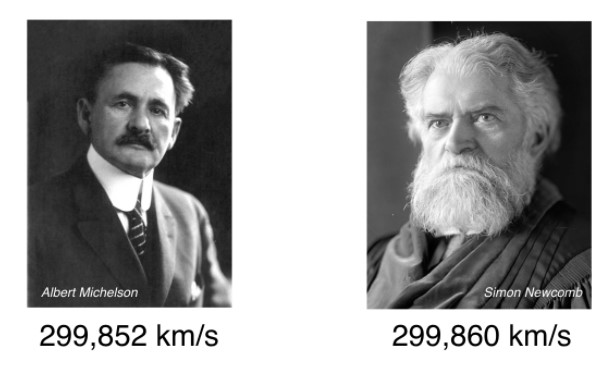

In [20]:
## Hình minh họa Image(fig1, height, width)

Newcomb's measurements had a mean of 299,860 km/s, differing from Michelson's by about 8 km/s. We want to know if there is something fundamentally different about Newcomb's and Michelson's measurements. The thing is: we only have Newcomb's mean and none of his data points!

The question is: could Michelson have gotten the data set he did if the true mean speed of light in his experiments was equal to Newcomb's? So, we formally state our hypothesis as this: the true mean speed of light in Michelson's experiments was actually Newcomb's reported mean, which we'll call the Newcomb value. 

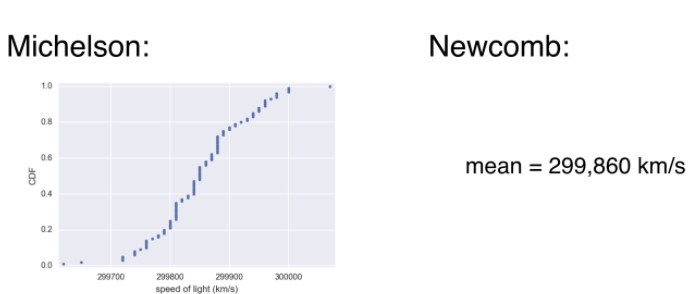

In [21]:
## Hình minh họa Image(fig1, height, width)

#### Null hypothesis.
When I say the true mean speed of light in Michelson's experiments, think the mean Michelson would have gotten had done his experiment lots and lots and lots of times. Because we are comparing a data set with a value, a permutation test is not applicable. We need to simulate the situation in which the true mean speed of light in Michelson's experiments is Newcomb's value.
#### Shifting the Michelson data
To achieve this, we shift Michelson's data such that its mean now matches Newcomb's value. See here the ECDF of the shifted data relative to the original data. We can then use bootstrapping on this shifted data to simulate data acquisition under the null hypothesis.

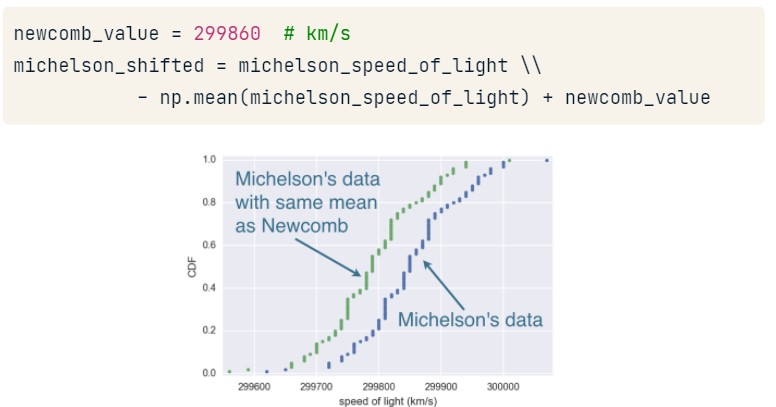

In [22]:
## Hình minh họa Image(fig1, height, width)

#### Calculating the test statistic
The test statistic is the the mean of the bootstrap sample minus Newcomb's value. We write a function `diff_from_newcomb` to compute it, and compute the observed test statistic.
#### Computing the p-value
We then use the `draw_bs_reps` function you have already written to generate the bootstrap replicates, which is the value of the test statistic computed from a bootstrap sample. Note that the data we pass into the function are the shifted Michelson measurements because those are the ones we use to simulate the null hypothesis. 

The `p-value` is computed exactly the same way as for the permutation test. We report the fraction of bootstrap replicates that are less than the observed test statistic. 

In this case, we use less than because the mean from Michelson's experiments was less than Newcomb's value. We get a `p-value` of `0.16`. This suggests that it is quite possible the Newcomb and Michelson did not really have fundamental differences in their measurements. This is an example of a one-sample test, since we had one set of samples from Michelson and were comparing to a single number from Newcomb.

#### One sample test
Often in the field, you will do two-sample tests that require the bootstrap, which you will explore in the exercises. I know this video was a lot to take in. 

Explicitly simulating a null hypothesis like this, we we have to shift the mean, can be tricky. You'll get a chance to practice in the exercises, and you may want to go over the procedure again to make sure you understand it.

### 4.2. PRACTICES.
#### Exercise 4.2.1. A one-sample bootstrap hypothesis test
Another juvenile frog was studied, Frog C, and you want to see if Frog B and Frog C have similar impact forces. Unfortunately, you do not have Frog C's impact forces available, but you know they have a mean of 0.55 N.

Because you don't have the original data, you cannot do a permutation test, and you cannot assess the hypothesis that the forces from Frog B and Frog C come from the same distribution. You will therefore test another, less restrictive hypothesis: The mean strike force of Frog B is equal to that of Frog C.

**Reminder**

In [23]:
def bootstrap_replicate_1d(data, func):
    """Generare boostrap replicate of 1D-data"""
    bs_sample = np.random.choice(data, size = len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

To set up the bootstrap hypothesis test, you will take the mean as our test statistic. Remember, your goal is to calculate the probability of getting a mean impact force less than or equal to what was observed for Frog B if the hypothesis that the true mean of Frog B's impact forces is equal to that of Frog C is true. 

You first translate all of the data of Frog B such that the mean is 0.55 N. This involves adding the mean force of Frog C and subtracting the mean force of Frog B from each measurement of Frog B. This leaves other properties of Frog B's distribution, such as the variance, unchanged.
#### SOLUTION.

In [24]:
# Make an array of translated impact forces: translated_force_b
translated_force_b = force_b - np.mean(force_b) + 0.55

# Take bootstrap replicates of Frog B's translated impact forces: bs_replicates
bs_replicates = draw_bs_reps(translated_force_b, np.mean, 10000)

# Compute fraction of replicates that are less than the observed Frog B force: p
p = np.sum(bs_replicates <= np.mean(force_b)) / 10000

# Print the p-value
print('p = ', p)

p =  0.0062


#### Exercise 4.2.2. A two-sample bootstrap hypothesis test for difference of means
We now want to test the hypothesis that `Frog A` and `Frog B` have the same mean impact force, but not necessarily the same distribution, which is also impossible with a permutation test.

To do the two-sample bootstrap test, we shift both arrays to have the same mean, since we are simulating the hypothesis that their means are, in fact, equal. We then draw bootstrap samples out of the shifted arrays and compute the `difference in means`. This constitutes a bootstrap replicate, and we generate many of them.

The `p-value` is the fraction of replicates with a difference in means greater than or equal to what was observed.

#### SOLUTION.

In [25]:
forces_concat = df['impact_force'].values
empirical_diff_means = np.mean(force_a)-np.mean(force_b)

# Compute mean of all forces: mean_force
mean_force = np.mean(forces_concat)

# Generate shifted arrays
force_a_shifted = force_a - np.mean(force_a) + mean_force
force_b_shifted = force_b - np.mean(force_b) + mean_force

# Compute 10,000 bootstrap replicates from shifted arrays
bs_replicates_a = draw_bs_reps(force_a_shifted, np.mean, size=10000)
bs_replicates_b = draw_bs_reps(force_b_shifted, np.mean, size=10000)

# Get replicates of difference of means: bs_replicates
bs_replicates = bs_replicates_a - bs_replicates_b

# Compute and print p-value: p
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)
print('p-value =', p)

p-value = 0.0042
